In [416]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#from time_series_modelling import SARIMAX_hyperparameter_tune

import sys
sys.path.append('/Users/AaranDaniel/Desktop/DSI/projects/Group_Project_5_GA/code/')
from time_series_plots import plot_time_series

In [417]:
df = pd.read_csv('../data/Master_data.csv', index_col='date', parse_dates=True)
df.drop(columns=['year', 'month'], inplace=True)
df.head()

,population,unemployment_rate,hourly_earnings_yoy,cpi_yoy,shelter_yoy,energy_yoy,medical_care_yoy,food_yoy,gasoline_yoy,imports_yoy,...,tax_other_to_government,tax_personal_current,tax_gov_social_insurance_domestic,tax_total_all_taxes,cc_rate_all_ns,mortgage_rate_30_yr,cc_bals_30d_due_percentage,cc_bals_90d_due_percentage,cc_balance_total_billions,credit_yoy
date,,,,,,,,,,,,,,,,,,,,,
2001-01-01,283960000.0,4.2,NaN,3.732227,3.252886,17.777778,4.538341,2.889825,13.143736,2.760736,...,5.118800e+10,1.289199e+12,7.281720e+11,2.068559e+12,.,7.0325,NaN,NaN,NaN,12.391364
2001-02-01,284166000.0,4.2,NaN,3.533569,3.457307,13.110540,4.600390,3.006615,8.400292,0.200602,...,5.152400e+10,1.303434e+12,7.330290e+11,2.087987e+12,15.63,7.0500,NaN,NaN,NaN,12.757135
2001-03-01,284380000.0,4.3,NaN,2.920561,3.496868,5.973813,4.540163,3.123123,-6.099935,-1.601602,...,5.189600e+10,1.313079e+12,7.357760e+11,2.100751e+12,.,6.9520,NaN,NaN,NaN,12.611905
2001-04-01,284602000.0,4.4,NaN,3.269119,3.595623,10.273405,4.643963,3.181273,3.851262,-0.710660,...,5.212400e+10,1.315105e+12,7.335270e+11,2.100756e+12,.,7.0775,NaN,NaN,NaN,12.895804
2001-05-01,284834000.0,4.3,NaN,3.615160,3.742204,15.785124,4.668210,3.108189,15.420561,-0.809717,...,5.246000e+10,1.310869e+12,7.328300e+11,2.096159e+12,15.06,7.1450,NaN,NaN,NaN,12.498904


In [418]:
df.corr(numeric_only=True)['credit_yoy'].sort_values(ascending=False)

credit_yoy                                                         1.000000
shelter_yoy                                                        0.520146
cpi_yoy                                                            0.448303
food_yoy                                                           0.320199
energy_yoy                                                         0.299519
mortgage_rate_30_yr                                                0.248460
gasoline_yoy                                                       0.202741
all_less_food_&_shelter_yoy                                        0.184390
imports_yoy                                                        0.164761
tax_personal_current                                               0.136099
cc_balance_total_billions                                          0.111787
hourly_earnings_yoy                                                0.108193
medical_care_yoy                                                   0.103553
new_&_used_v

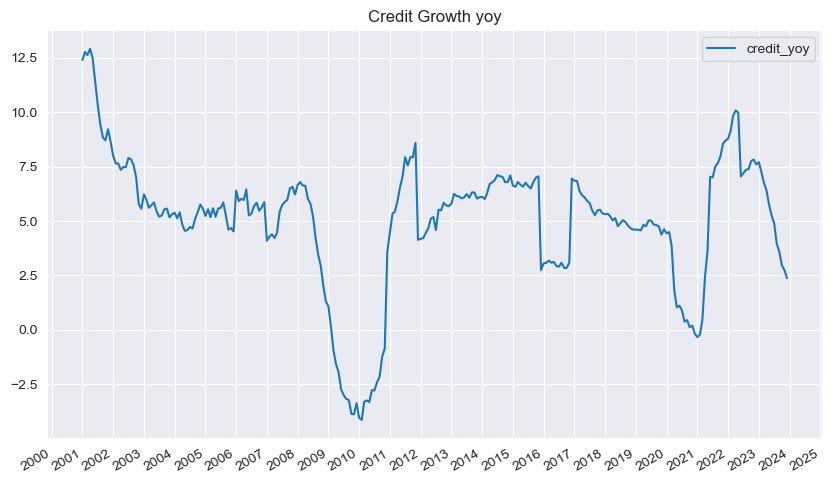

<Figure size 1000x600 with 0 Axes>

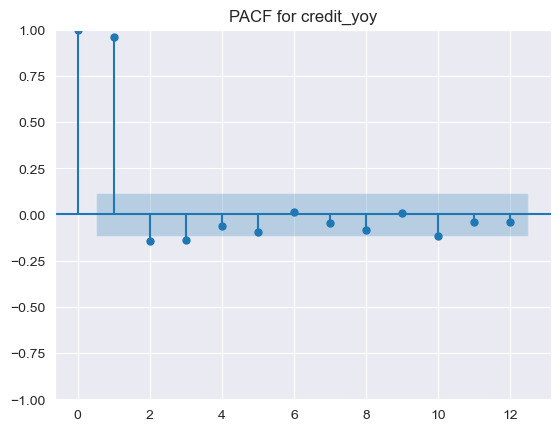

In [419]:
plot_time_series(df, columns = ['credit_yoy'],title = 'Credit Growth yoy', pacf=True);

First endogenous baseline model will use p of 1 based on the idea that:

"If the PACF (partial autocorrelation function) has a sharp cut-off and the lag-1 PACF value is positive, choose $p$ to be the lag in the PACF before the cut-off. If the PACF does not have a sharp cut-off or the lag-1 ACF value is not positive, then let $p=0$."

q will equal 

In [420]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

interpret_dftest(adfuller(df['credit_yoy']))

Test Statistic   -2.840773
p-value           0.052681
dtype: float64

In [421]:
# lets do d = 1 based on below results
df_lag = df.copy()
df_lag['credit_yoy_lag1'] = df_lag['credit_yoy'].diff(1)
interpret_dftest(adfuller(df_lag['credit_yoy_lag1'].dropna()))

Test Statistic   -6.401630e+00
p-value           1.988921e-08
dtype: float64

d = 1 based on above p-value which is less when 0.05

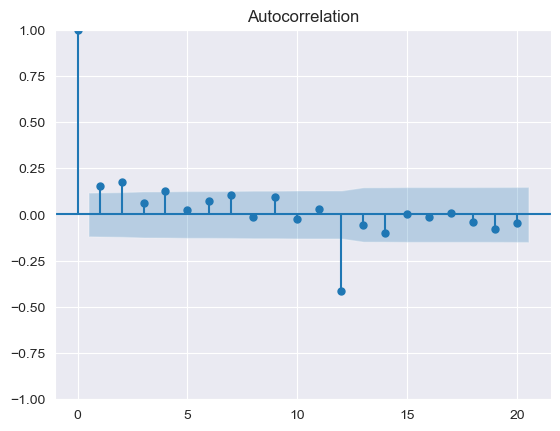

In [422]:
plot_acf(df_lag['credit_yoy_lag1'].dropna(), lags=20);

q will equal 0 because the first lag is positive, in the auto correlation function.

## Baseline ARIMA model 

In [423]:
df.columns

Index(['population', 'unemployment_rate', 'hourly_earnings_yoy', 'cpi_yoy',
       'shelter_yoy', 'energy_yoy', 'medical_care_yoy', 'food_yoy',
       'gasoline_yoy', 'imports_yoy', 'new_&_used_vehicles_yoy',
       'all_less_food_&_shelter_yoy', 'total_personal_income',
       'total_employee_compensation', 'wages_and_salaries_all',
       'wages_salaries_private_employees',
       'wages_salaries_government_employees',
       'employer_contributions_for_employee_pension_and_insurance_funds',
       'employer_contributions_for_government_social_insurance',
       'rental_income_(capital_consumption_adjusted)',
       'personal_dividend_income', 'personal_interest_income',
       'total_gov_social_benefits', 'social_security', 'medicare', 'medicaid',
       'unemployment_insurance', 'veterans'_benefits',
       'total_disposible_personal_income_chained_2017',
       'total_personal_savings',
       'personal_saving_as_a_percentage_of_disposable_personal_income',
       'disp_inc_per_ca

In [424]:
X_nonscaled = df.drop(columns=['credit_yoy', 'cc_rate_all_ns'])
y = df['credit_yoy']

In [425]:
# Standard scale X
ss = StandardScaler()

X = ss.fit_transform(X_nonscaled)
X = pd.DataFrame(X, index=X_nonscaled.index, columns=X_nonscaled.columns)
X


,population,unemployment_rate,hourly_earnings_yoy,cpi_yoy,shelter_yoy,energy_yoy,medical_care_yoy,food_yoy,gasoline_yoy,imports_yoy,...,total_all_personal_outlays,personal_interest_payments,tax_other_to_government,tax_personal_current,tax_gov_social_insurance_domestic,tax_total_all_taxes,mortgage_rate_30_yr,cc_bals_30d_due_percentage,cc_bals_90d_due_percentage,cc_balance_total_billions
date,,,,,,,,,,,,,,,,,,,,,
2001-01-01,-1.859529,-0.831750,NaN,0.657358,0.163832,0.987939,1.006524,-0.009527,0.296820,0.148321,...,-1.478936,-0.596289,-1.786493,-0.759218,-1.337861,-0.983301,1.651984,NaN,NaN,NaN
2001-02-01,-1.846451,-0.831750,NaN,0.548878,0.296281,0.640222,1.056895,0.042586,0.088003,-0.217255,...,-1.474323,-0.597642,-1.771009,-0.734815,-1.321626,-0.961639,1.665901,NaN,NaN,NaN
2001-03-01,-1.832865,-0.781085,NaN,0.214138,0.321913,0.108524,1.008003,0.094573,-0.550329,-0.474601,...,-1.476019,-0.606907,-1.753865,-0.718281,-1.312443,-0.947407,1.587966,NaN,NaN,NaN
2001-04-01,-1.818771,-0.730420,NaN,0.404472,0.385898,0.428851,1.092267,0.120520,-0.112255,-0.347379,...,-1.473431,-0.612410,-1.743358,-0.714807,-1.319961,-0.947401,1.687770,NaN,NaN,NaN
2001-05-01,-1.804042,-0.781085,NaN,0.593432,0.480871,0.839483,1.111951,0.087909,0.397051,-0.361524,...,-1.458403,-0.628718,-1.727874,-0.722069,-1.322291,-0.952527,1.741449,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,1.408202,-1.034410,1.242718,0.620709,2.752925,-0.605976,-3.460109,0.599237,-0.438520,-0.670534,...,2.326222,3.880136,1.900421,1.761062,2.292952,1.956266,1.683396,NaN,NaN,NaN
2023-09-01,1.419693,-1.034410,1.231044,0.639595,2.686170,-0.370085,-3.828724,0.348526,-0.160426,-0.455453,...,2.384026,4.561347,1.913694,1.779902,2.314335,1.975974,1.785188,NaN,NaN,NaN
2023-10-01,1.429915,-1.034410,1.033066,0.389197,2.417198,-0.673996,-3.305479,0.173829,-0.538300,-0.496067,...,2.385705,4.568513,1.927703,1.766832,2.325340,1.971482,2.119193,NaN,NaN,NaN


In [426]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.15,
                                                    shuffle = False) 
y_train.index.freq = 'MS'
y_test.index.freq = 'MS'
y_train.index.freq = 'MS'
y_test.index.freq = 'MS'

In [427]:
model = ARIMA(endog=y_train.astype(float).dropna(), 
              order = (1, 1, 0),) # p, d, q

In [428]:
arima_1_1_0 = model.fit()

In [429]:
y_test

date
2020-07-01     0.902552
2020-08-01     0.380780
2020-09-01     0.449483
2020-10-01     0.128756
2020-11-01     0.205011
2020-12-01    -0.175061
2021-01-01    -0.330509
2021-02-01    -0.205600
2021-03-01     0.466657
2021-04-01     2.437071
2021-05-01     3.610941
2021-06-01     7.024071
2021-07-01     7.000940
2021-08-01     7.500785
2021-09-01     7.663382
2021-10-01     7.959316
2021-11-01     8.549534
2021-12-01     8.690476
2022-01-01     8.776977
2022-02-01     9.154833
2022-03-01     9.833094
2022-04-01    10.073821
2022-05-01     9.961450
2022-06-01     7.045462
2022-07-01     7.192072
2022-08-01     7.349697
2022-09-01     7.381099
2022-10-01     7.748737
2022-11-01     7.818444
2022-12-01     7.595966
2023-01-01     7.697741
2023-02-01     7.234624
2023-03-01     6.762653
2023-04-01     6.414150
2023-05-01     5.762839
2023-06-01     5.254929
2023-07-01     4.910374
2023-08-01     3.964872
2023-09-01     3.577056
2023-10-01     2.967773
2023-11-01     2.745921
2023-12-01 

In [430]:
preds = arima_1_1_0.predict(start = datetime(2020, 7, 1), end = datetime(2023, 12, 1))

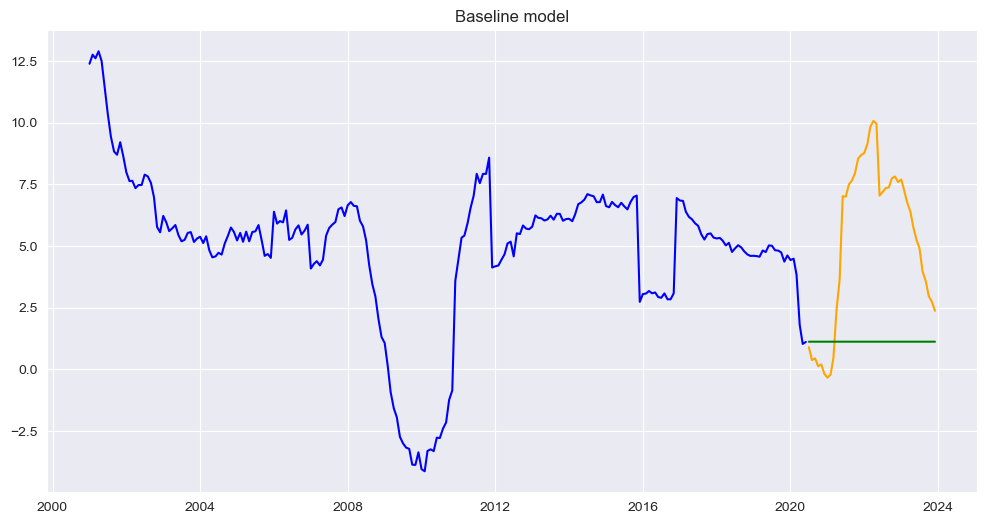

In [431]:
plt.figure(figsize=(12,6))

plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')

plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Baseline model', fontsize=12);

In [432]:
print(arima_1_1_0.aic)


506.329538593552


## SARIMA Model (no exodogenous variables)

In [433]:
from pmdarima import auto_arima

In [434]:
sarima_model = auto_arima(y_train,
                       start_P=0,
                       start_q=0,
                       max_d = 3,
                       max_p=3,
                       max_q=3,
                       max_D = 3, 
                       max_P=3, 
                       max_Q=3, 
                       m=1, # is monthly 
                       seasonal=True,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
sarima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=506.313, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=507.979, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=507.473, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=507.955, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=507.048, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=508.219, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=506.916, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=505.245, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=506.927, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=507.171, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=508.265, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=503.803, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=506.864, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=506.330, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=505.4

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  234
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -248.901
Date:                Sun, 18 Feb 2024   AIC                            503.803
Time:                        10:57:25   BIC                            514.156
Sample:                    01-01-2001   HQIC                           507.978
                         - 06-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8034      0.206      3.906      0.000       0.400       1.207
ma.L1         -0.6971      0.261     -2.669      0.008      -1.209      -0.185
sigma2         0.4958      0.015     32.835      0.000       0.466       0.525
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):              4575.69
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.97   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [435]:
sarima = SARIMAX(endog = y_train,
                order = (1,1,1),              # (p, d, q)
                seasonal_order = (0,0,0,0),  # (P, D, Q, S) 
                seasonal = True, 
                shuffle = False)

# Fit SARIMAX model.
result = sarima.fit(disp=False)

# Generate predictions based on test set.
preds_noexog = result.predict(
                    start = datetime((int(str(y_test.index[0])[0:4])), 
                                        int(str(y_test.index[0])[5:7]), 
                                        int(str(y_test.index[0])[8:10])),
                    end = datetime((int(str(y_test.index[-1])[0:4])), 
                                    int(str(y_test.index[-1])[5:7]), 
                                    int(str(y_test.index[-1])[8:10])))

/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal', 'shuffle']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


503.8029729678302


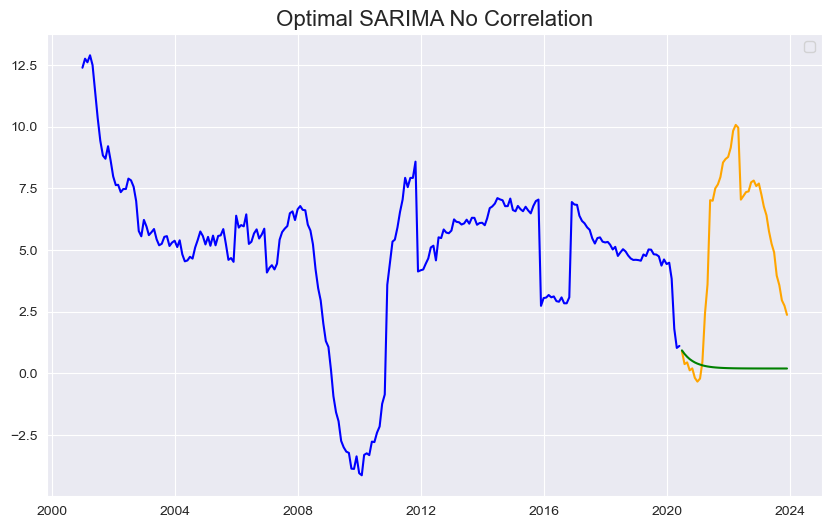

In [436]:
# Evaluate predictions.
print(result.aic)

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds_noexog, color = 'green')
plt.title(label = 'Optimal SARIMA No Correlation', fontsize=16)
plt.legend()
plt.show();

## SARIMAX model

In [437]:
X_train_exog = X_train[['personal_saving_as_a_percentage_of_disposable_personal_income', 
                        'unemployment_insurance',
                        'mortgage_rate_30_yr', 
                        'shelter_yoy', 
                        'unemployment_rate', 
                        'cpi_yoy']]
X_test_exog = X_test[['personal_saving_as_a_percentage_of_disposable_personal_income', 
                      'unemployment_insurance',
                      'mortgage_rate_30_yr', 
                      'shelter_yoy', 
                      'unemployment_rate', 
                      'cpi_yoy']]
                      

In [438]:
# source: https://sailajakarra.medium.com/time-series-predictions-using-arima-sarimax-e6724844cae0 

sarimax_model = auto_arima(y_train,
                       start_P=0,
                       start_q=0,
                       max_d = 3,
                       max_p=3,
                       max_q=3,
                       max_D = 3, 
                       max_P=3, 
                       exogenous = X_train_exog,
                       max_Q=3, 
                       m=1, # is monthly 
                       seasonal=True,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
sarimax_model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=506.313, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=507.979, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=507.473, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=507.955, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=507.048, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=508.219, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=506.916, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=505.245, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=506.927, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=507.171, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=508.265, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=503.803, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=506.864, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=506.330, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=505.4

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  234
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -248.901
Date:                Sun, 18 Feb 2024   AIC                            503.803
Time:                        10:57:27   BIC                            514.156
Sample:                    01-01-2001   HQIC                           507.978
                         - 06-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8034      0.206      3.906      0.000       0.400       1.207
ma.L1         -0.6971      0.261     -2.669      0.008      -1.209      -0.185
sigma2         0.4958      0.015     32.835      0.000       0.466       0.525
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):              4575.69
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.97   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [439]:
sarimax_ex = SARIMAX(endog = y_train,
                order = (1,1,1),              # (p, d, q)
                seasonal_order = (0,0,0,0),  # (P, D, Q, S)
                exog = X_train_exog.dropna(), 
                seasonal = True, 
                shuffle = False)

# Fit SARIMAX model.
results_s_ex = sarimax_ex.fit(disp=False)

# Generate predictions based on test set.
preds_s_ex = results_s_ex.predict(
                    start = datetime((int(str(y_test.index[0])[0:4])), 
                                        int(str(y_test.index[0])[5:7]), 
                                        int(str(y_test.index[0])[8:10])),
                    end = datetime((int(str(y_test.index[-1])[0:4])), 
                                    int(str(y_test.index[-1])[5:7]), 
                                    int(str(y_test.index[-1])[8:10])),
                    exog = X_test_exog.dropna())

/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal', 'shuffle']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal', 'shuffle']).Passing unknown keyword arguments will raise a TypeError beginning i

493.6513822981209
0.9875088240501071


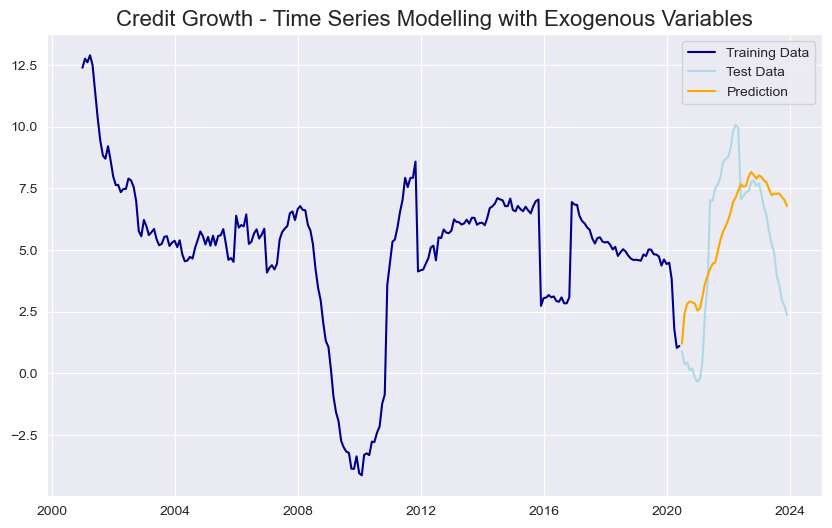

In [463]:
# Evaluate predictions.
print(results_s_ex.aic)
print(np.sqrt(results_s_ex.mse))

# Plot data.
plt.figure(figsize=(10, 6))
plt.plot(y_train, color='darkblue', label='Training Data')
plt.plot(y_test, color='lightblue', label='Test Data')
plt.plot(preds_s_ex, color='orange', label='Prediction')
plt.title('Credit Growth - Time Series Modelling with Exogenous Variables', fontsize=16)
plt.legend()  # Adds the legend to the plot
plt.show();

## Try with pre-covid only data

In [441]:
X_train_precov, X_test_precov, y_train_precov, y_test_precov = train_test_split(X,
                                                    y,
                                                    test_size = 0.17,
                                                    shuffle = False) 

In [442]:
sarimax_model_precov = auto_arima(y_train_precov,
                       start_P=0,
                       start_q=0,
                       exogenous = X_train_precov,
                       max_d = 3,
                       max_p=3,
                       max_q=3,
                       max_D = 3, 
                       max_P=3, 
                       max_Q=3, 
                       m=1, # is monthly 
                       seasonal=True,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
sarimax_model_precov.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=491.372, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=492.544, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=492.854, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=493.192, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=491.099, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=490.510, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=491.876, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=491.899, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=492.312, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=493.121, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=488.779, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=491.679, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=491.319, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=490.138, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=490.1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  229
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -241.390
Date:                Sun, 18 Feb 2024   AIC                            488.779
Time:                        10:57:29   BIC                            499.067
Sample:                    01-01-2001   HQIC                           492.930
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8065      0.209      3.858      0.000       0.397       1.216
ma.L1         -0.7081      0.266     -2.661      0.008      -1.230      -0.187
sigma2         0.4864      0.015     32.745      0.000       0.457       0.516
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):              5004.61
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                            -0.48
Prob(H) (two-sided):                  0.01   Kurtosis:                        25.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal', 'shuffle']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive

505.67316340208885


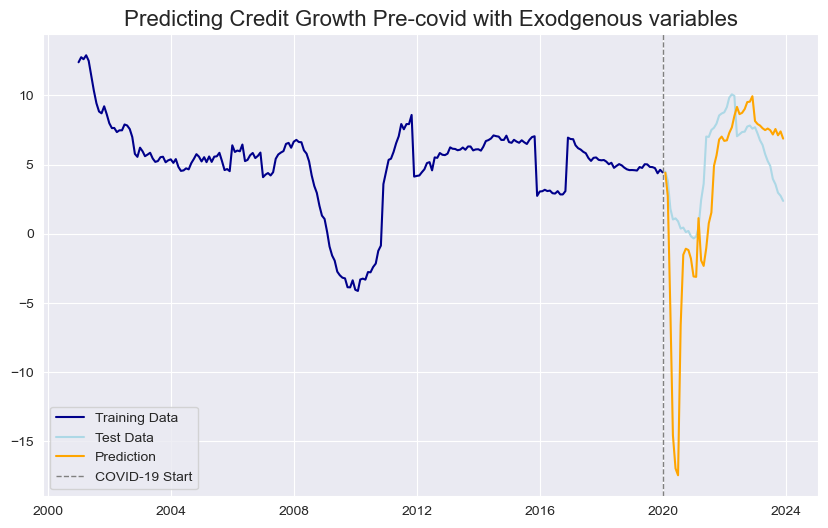

In [443]:
X_train_exog_precov = X_train_precov.drop(columns = [
    'cc_balance_total_billions',
    'cc_bals_90d_due_percentage',
    'cc_bals_30d_due_percentage',
    'hourly_earnings_yoy'])
X_test_exog_precov = X_test_precov.drop(columns = [
    'cc_balance_total_billions',
    'cc_bals_90d_due_percentage',
    'cc_bals_30d_due_percentage',
    'hourly_earnings_yoy'])


sarimax_precov = SARIMAX(endog = y_train_precov,
                order = (1,1,1),              # (p, d, q)
                seasonal_order = (0,0,0,0),  # (P, D, Q, S)
                exog = X_train_exog_precov.dropna(), 
                seasonal = True, 
                shuffle = False)

results_precov = sarimax_precov.fit(disp=False)

# Generate predictions based on test set.
preds_precov = results_precov.predict(
                    start = datetime((int(str(y_test_precov.index[0])[0:4])), 
                                        int(str(y_test_precov.index[0])[5:7]), 
                                        int(str(y_test_precov.index[0])[8:10])),
                    end = datetime((int(str(y_test_precov.index[-1])[0:4])), 
                                    int(str(y_test_precov.index[-1])[5:7]), 
                                    int(str(y_test_precov.index[-1])[8:10])),
                    exog = X_test_exog_precov.dropna())
# Evaluate predictions.
print(results_precov.aic)

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(y_train_precov, color='darkblue', label='Training Data')
plt.plot(y_test_precov, color='lightblue', label='Test Data')
plt.plot(preds_precov, color='orange', label='Prediction')
plt.title(label = 'Predicting Credit Growth Pre-covid with Exodgenous variables', fontsize=16)
plt.axvline(pd.Timestamp('2020-01-10'), color='grey', linestyle='--', lw=1, label='COVID-19 Start')
plt.legend()  
plt.show();

# Training Model on All Data and Predicting Future Credit Growth

In [444]:
last_date = df.index.max()
extended_date_range = pd.date_range(start=last_date, periods=13, freq='MS')


In [445]:
df_ext = df.reindex(df.index.union(extended_date_range))
df_ext

,population,unemployment_rate,hourly_earnings_yoy,cpi_yoy,shelter_yoy,energy_yoy,medical_care_yoy,food_yoy,gasoline_yoy,imports_yoy,...,tax_other_to_government,tax_personal_current,tax_gov_social_insurance_domestic,tax_total_all_taxes,cc_rate_all_ns,mortgage_rate_30_yr,cc_bals_30d_due_percentage,cc_bals_90d_due_percentage,cc_balance_total_billions,credit_yoy
2001-01-01,283960000.0,4.2,NaN,3.732227,3.252886,17.777778,4.538341,2.889825,13.143736,2.760736,...,5.118800e+10,1.289199e+12,7.281720e+11,2.068559e+12,.,7.0325,NaN,NaN,NaN,12.391364
2001-02-01,284166000.0,4.2,NaN,3.533569,3.457307,13.110540,4.600390,3.006615,8.400292,0.200602,...,5.152400e+10,1.303434e+12,7.330290e+11,2.087987e+12,15.63,7.0500,NaN,NaN,NaN,12.757135
2001-03-01,284380000.0,4.3,NaN,2.920561,3.496868,5.973813,4.540163,3.123123,-6.099935,-1.601602,...,5.189600e+10,1.313079e+12,7.357760e+11,2.100751e+12,.,6.9520,NaN,NaN,NaN,12.611905
2001-04-01,284602000.0,4.4,NaN,3.269119,3.595623,10.273405,4.643963,3.181273,3.851262,-0.710660,...,5.212400e+10,1.315105e+12,7.335270e+11,2.100756e+12,.,7.0775,NaN,NaN,NaN,12.895804
2001-05-01,284834000.0,4.3,NaN,3.615160,3.742204,15.785124,4.668210,3.108189,15.420561,-0.809717,...,5.246000e+10,1.310869e+12,7.328300e+11,2.096159e+12,15.06,7.1450,NaN,NaN,NaN,12.498904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [446]:
X_f = df_ext.drop(columns=['credit_yoy', 'cc_rate_all_ns', 
                     'cc_bals_30d_due_percentage', 
                     'cc_bals_90d_due_percentage', 
                     'cc_balance_total_billions',
                     'hourly_earnings_yoy' ])
y_f = df_ext['credit_yoy']

In [447]:
for column in X_f.columns:
    X_f[f"{column}_shift12m"] = X_f[column].shift(12)

In [448]:
X_f.drop(columns = ['population', 'unemployment_rate', 'cpi_yoy', 'shelter_yoy',
                    'energy_yoy', 'medical_care_yoy', 'food_yoy', 'gasoline_yoy',
                    'imports_yoy', 'new_&_used_vehicles_yoy', 'all_less_food_&_shelter_yoy',
                    'total_personal_income', 'total_employee_compensation',
                    'wages_and_salaries_all', 'wages_salaries_private_employees',
                    'wages_salaries_government_employees',
                    'employer_contributions_for_employee_pension_and_insurance_funds',
                    'employer_contributions_for_government_social_insurance',
                    'rental_income_(capital_consumption_adjusted)',
                    'personal_dividend_income', 'personal_interest_income',
                    'total_gov_social_benefits', 'social_security', 'medicare', 'medicaid',
                    'unemployment_insurance', "veterans'_benefits",
                    'total_disposible_personal_income_chained_2017',
                    'total_personal_savings',
                    'personal_saving_as_a_percentage_of_disposable_personal_income',
                    'disp_inc_per_capita_chained_2017', 'total_disposable_personal_income',
                    'disp_inc_per_capita_current_dollars', 'total_all_personal_outlays',
                    'personal_interest_payments', 'tax_other_to_government',
                    'tax_personal_current', 'tax_gov_social_insurance_domestic',
                    'tax_total_all_taxes', 'mortgage_rate_30_yr'], inplace=True)

In [449]:
#y_f = y_f.shift(12)

In [450]:
# X_f_train

In [451]:
X_f_train = X_f.first('276M') # 2002-23
X_f_validation = X_f.last('12M') # 2023-24 to be used for forcasting
y_f_train = y_f.first('276M')  # 2002-23
y_f_validation = y_f.last('12M')  # 2023-24 used to check forcasting?

X_f_train.dropna(inplace=True)
X_f_validation.dropna(inplace=True)
y_f_train.dropna(inplace=True) 

/var/folders/8r/dqs6y1qn77d917x96kct6x5h0000gn/T/ipykernel_81139/2817523538.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_f_train.dropna(inplace=True)
/var/folders/8r/dqs6y1qn77d917x96kct6x5h0000gn/T/ipykernel_81139/2817523538.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_f_validation.dropna(inplace=True)


In [452]:
y_f_train = y_f_train.last('264M')

In [453]:
# check sizes of all 
print(X_f_train.shape)
print(X_f_validation.shape)
print(y_f_train.shape)
print(y_f_validation.shape)

(264, 40)
(12, 40)
(264,)
(12,)


In [454]:
sarimax_forecast = SARIMAX(endog = y_f_train,
                order = (1,1,1),             # (p, d, q)
                seasonal_order = (0,0,0,0),  # (P, D, Q, S)
                exog = X_f_train, 
                seasonal = True, 
                shuffle = False)

results_forecast = sarimax_forecast.fit(disp=False)

/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal', 'shuffle']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [455]:
preds_forecast = results_forecast.predict(
                                        start = datetime(2023, 12, 1),
                                        end = datetime(2024, 12, 1),         
                                        exog = X_f_validation)

/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal', 'shuffle']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


493.6513822981209


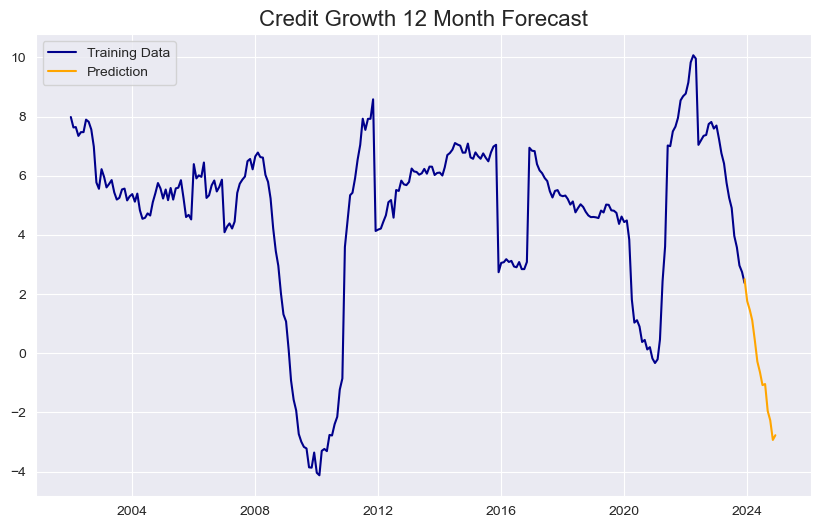

In [456]:
# Evaluate predictions.
print(results_s_ex.aic)

# Plot data.
plt.figure(figsize=(10, 6))
plt.plot(y_f_train, color='darkblue', label='Training Data')
plt.plot(preds_forecast, color='orange', label='Prediction')
plt.title('Credit Growth 12 Month Forecast', fontsize=16)
plt.legend()  
plt.show();